# FX Benchmark Analysis

This notebook analyzes FX benchmark data collected from the Deluge.

## Prerequisites

1. Build with benchmarking: `./dbt configure -DENABLE_FX_BENCHMARK=ON -DENABLE_SYSEX_LOAD=YES && ./dbt build release`
2. Collect data: `./dbt fx-benchmark --collect -o fx_benchmark.csv`
3. Place `fx_benchmark.csv` in this directory or update the path below

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuration
CSV_PATH = "../../fx_benchmark.csv"  # Update path if needed
CPU_FREQ_HZ = 400_000_000  # 400 MHz Cortex-A9
SAMPLE_RATE = 44100
BUFFER_SIZE = 128  # SSI_TX_BUFFER_NUM_SAMPLES

# Calculate cycles per audio buffer at 100% CPU
CYCLES_PER_BUFFER = CPU_FREQ_HZ / SAMPLE_RATE * BUFFER_SIZE
print(f"CPU: {CPU_FREQ_HZ / 1e6:.0f} MHz")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Buffer size: {BUFFER_SIZE} samples")
print(f"Cycles per buffer (100% CPU): {CYCLES_PER_BUFFER:,.0f}")

CPU: 400 MHz
Sample rate: 44100 Hz
Buffer size: 128 samples
Cycles per buffer (100% CPU): 1,160,998


In [10]:
# Load benchmark data
df = pd.read_csv(CSV_PATH)

# Parse tags column (comma-separated)
df["tags_list"] = df["tags"].fillna("").apply(lambda x: x.split(",") if x else [])

print(f"Loaded {len(df)} samples")
print(f"Effects: {df['fx'].unique().tolist()}")
df.head()

Loaded 1222 samples
Effects: ['reverb_mutable', 'automod']


,fx,cycles,ts,tags,tags_list
0,reverb_mutable,12118,748103612,NaN,[]
1,reverb_mutable,6609,1122181316,NaN,[]
2,automod,1194,1507496795,setup,[setup]
3,automod,3733,1507498134,loop,[loop]
4,automod,5396,1507496591,total,[total]


## Summary Statistics

In [11]:
# Filter to "total" entries for effects that have substage breakdown
# Effects with substages (setup/loop/total, crossover/envelope/recombine/total, etc.)
# should only use "total" rows in the main summary

# Known substage tag keywords (not "total")
SUBSTAGE_KEYWORDS = {
    # sine_shaper substages
    "setup",
    "loop",
    # multiband substages
    "crossover",
    "envelope",
    "recombine",
    # scatter substages
    "slice",
    "params",
    "paramread",
    "static",
    "envprep",
    "env",
    "pan",
    "delay",
    "record",
    "read",
    "advance",
}


def is_total_or_non_substage(row):
    """Return True if this row represents total DSP (not a substage)

    Logic:
    - If tags contain "total", include it (it's the total measurement)
    - If tags contain any known substage keyword, exclude it
    - Otherwise include (untagged or non-substage tags like reverb model, stage count)
    """
    tags = row["tags"] if pd.notna(row["tags"]) else ""
    tags_lower = tags.lower()

    # If "total" is present, it's the total measurement
    if "total" in tags_lower:
        return True

    # Check for any known substage keywords
    for kw in SUBSTAGE_KEYWORDS:
        if kw in tags_lower:
            return False

    # Not tagged as substage - include it
    return True


df_totals = df[df.apply(is_total_or_non_substage, axis=1)].copy()

print(f"Filtered to {len(df_totals)} total/non-substage samples (from {len(df)} total)")
print(f"Excluded substage keywords: {sorted(SUBSTAGE_KEYWORDS)}")

# Calculate summary statistics per effect using only totals
summary = df_totals.groupby("fx")["cycles"].agg(
    ["count", "mean", "std", "median", "min", "max"]
)

# Add CPU percentage column
summary["cpu_percent"] = (summary["mean"] / CYCLES_PER_BUFFER) * 100

# Format nicely
summary = summary.round(2)
summary = summary.sort_values("mean", ascending=False)

print("\nFX Benchmark Summary (sorted by mean cycles):")
print("=" * 80)
print(summary.to_string())
print("\nNote: cpu_percent is approximate load per audio buffer")
print("Note: Only 'total' tagged entries used for effects with substage breakdown")

Filtered to 612 total/non-substage samples (from 1222 total)
Excluded substage keywords: ['advance', 'crossover', 'delay', 'env', 'envelope', 'envprep', 'loop', 'pan', 'paramread', 'params', 'read', 'recombine', 'record', 'setup', 'slice', 'static']

FX Benchmark Summary (sorted by mean cycles):
                count     mean      std  median   min    max  cpu_percent
fx                                                                       
reverb_mutable    307  9898.41  2641.13  9472.0  3133  21359         0.85
automod           305  5639.50   939.84  5390.0  3107   9819         0.49

Note: cpu_percent is approximate load per audio buffer
Note: Only 'total' tagged entries used for effects with substage breakdown


## Histograms by Effect

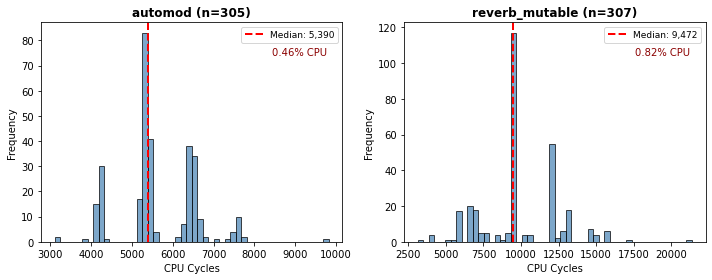

Saved: fx_benchmark_histograms.png


In [12]:
# Create histogram subplots for each effect (using totals only)
effects = df_totals["fx"].unique()
n_effects = len(effects)

# Calculate grid dimensions
n_cols = min(3, n_effects)
n_rows = (n_effects + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
if n_effects == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, fx_name in enumerate(sorted(effects)):
    ax = axes[idx]
    fx_data = df_totals[df_totals["fx"] == fx_name]["cycles"]

    # Histogram
    ax.hist(fx_data, bins=50, edgecolor="black", alpha=0.7, color="steelblue")

    # Add median line
    median_val = fx_data.median()
    ax.axvline(
        median_val,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Median: {median_val:,.0f}",
    )

    # Labels
    ax.set_title(f"{fx_name} (n={len(fx_data)})", fontsize=12, fontweight="bold")
    ax.set_xlabel("CPU Cycles")
    ax.set_ylabel("Frequency")
    ax.legend(loc="upper right", fontsize=9)

    # Add CPU percentage annotation
    cpu_pct = (median_val / CYCLES_PER_BUFFER) * 100
    ax.annotate(
        f"{cpu_pct:.2f}% CPU",
        xy=(0.95, 0.85),
        xycoords="axes fraction",
        ha="right",
        fontsize=10,
        color="darkred",
    )

# Hide unused subplots
for idx in range(n_effects, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(
    "fx_benchmark_histograms.png", dpi=150, bbox_inches="tight", facecolor="white"
)
plt.show()
print("Saved: fx_benchmark_histograms.png")

## CPU Load Comparison (Bar Chart)

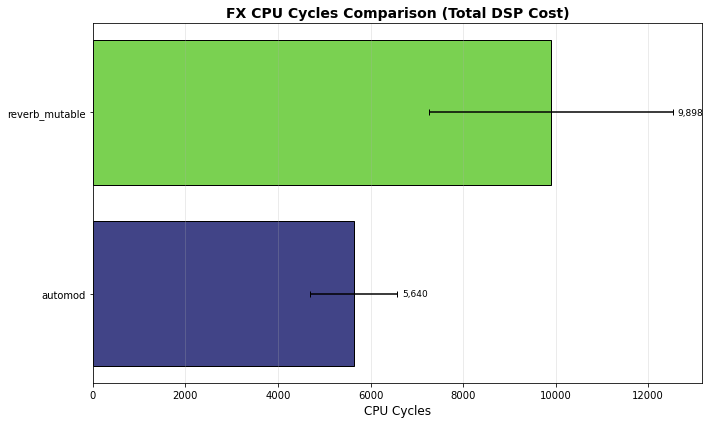

Saved: fx_benchmark_comparison.png


In [13]:
# Bar chart comparing average CPU cycles (using totals only)
fig, ax = plt.subplots(figsize=(10, 6))

fx_means = df_totals.groupby("fx")["cycles"].mean().sort_values(ascending=True)
fx_stds = df_totals.groupby("fx")["cycles"].std().reindex(fx_means.index)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(fx_means)))

bars = ax.barh(
    range(len(fx_means)),
    fx_means,
    xerr=fx_stds,
    color=colors,
    edgecolor="black",
    capsize=3,
)

ax.set_yticks(range(len(fx_means)))
ax.set_yticklabels(fx_means.index)
ax.set_xlabel("CPU Cycles", fontsize=12)
ax.set_title(
    "FX CPU Cycles Comparison (Total DSP Cost)", fontsize=14, fontweight="bold"
)
ax.grid(axis="x", alpha=0.3)

# Add value labels
for i, (cycles, bar) in enumerate(zip(fx_means, bars)):
    ax.text(
        cycles + fx_stds.iloc[i] + 100, i, f"{cycles:,.0f}", va="center", fontsize=9
    )

plt.tight_layout()
plt.savefig(
    "fx_benchmark_comparison.png", dpi=150, bbox_inches="tight", facecolor="white"
)
plt.show()
print("Saved: fx_benchmark_comparison.png")

## Time Series (Optional)

If you collected data over time, this shows how cycle counts vary.

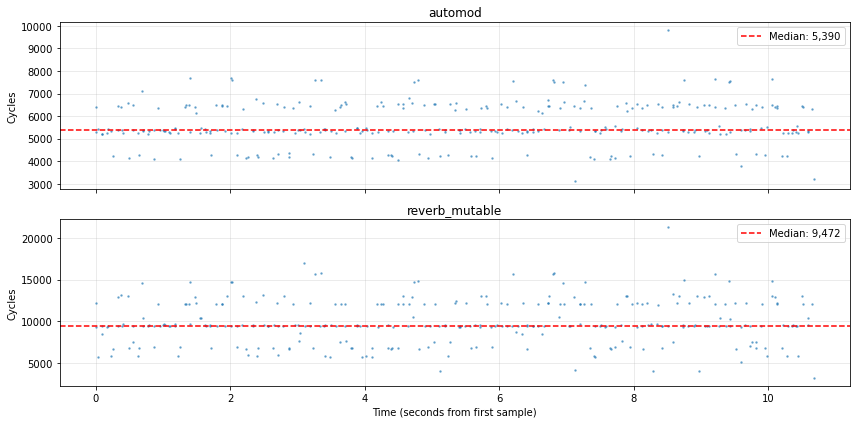

Saved: fx_benchmark_timeseries.png


In [14]:
# Time series plot - cycles over timestamp (using totals only)
if "ts" in df_totals.columns and df_totals["ts"].notna().any():
    fig, axes = plt.subplots(
        len(effects), 1, figsize=(12, 3 * len(effects)), sharex=True
    )
    if len(effects) == 1:
        axes = [axes]

    for ax, fx_name in zip(axes, sorted(effects)):
        fx_data = df_totals[df_totals["fx"] == fx_name].sort_values("ts")

        # Normalize timestamp to seconds from start
        if len(fx_data) > 0:
            t0 = fx_data["ts"].iloc[0]
            time_sec = (fx_data["ts"] - t0) / CPU_FREQ_HZ

            ax.plot(time_sec, fx_data["cycles"], ".", alpha=0.5, markersize=3)
            ax.axhline(
                fx_data["cycles"].median(),
                color="red",
                linestyle="--",
                label=f"Median: {fx_data['cycles'].median():,.0f}",
            )
            ax.set_ylabel("Cycles")
            ax.set_title(fx_name)
            ax.legend(loc="upper right")
            ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Time (seconds from first sample)")
    plt.tight_layout()
    plt.savefig(
        "fx_benchmark_timeseries.png", dpi=150, bbox_inches="tight", facecolor="white"
    )
    plt.show()
    print("Saved: fx_benchmark_timeseries.png")
else:
    print("No timestamp data available for time series plot")

## Analysis by Tags

If effects have tags (like multiband stages: crossover, envelope, recombine), analyze them separately.

In [15]:
# Check if we have tagged data
df_with_tags = df[df["tags"].notna() & (df["tags"] != "")]

if len(df_with_tags) > 0:
    print("Effects with tags:")
    for fx in df_with_tags["fx"].unique():
        fx_tags = df_with_tags[df_with_tags["fx"] == fx]
        print(f"\n{fx}:")
        for tag in fx_tags["tags"].unique():
            tag_data = fx_tags[fx_tags["tags"] == tag]["cycles"]
            print(
                f"  {tag}: {len(tag_data)} samples, median {tag_data.median():,.0f} cycles"
            )
else:
    print("No tagged data found")

Effects with tags:

automod:
  setup: 305 samples, median 1,182 cycles
  loop: 305 samples, median 3,729 cycles
  total: 305 samples, median 5,390 cycles


In [16]:
# Export summary to markdown for documentation
print("\n## Markdown Summary (copy to docs)\n")
print("| Effect | Count | Mean | Median | Std | CPU % |")
print("|--------|-------|------|--------|-----|-------|")
for fx in summary.index:
    row = summary.loc[fx]
    print(
        f"| {fx} | {int(row['count'])} | {row['mean']:,.0f} | {row['median']:,.0f} | {row['std']:,.0f} | {row['cpu_percent']:.2f}% |"
    )


## Markdown Summary (copy to docs)

| Effect | Count | Mean | Median | Std | CPU % |
|--------|-------|------|--------|-----|-------|
| reverb_mutable | 307 | 9,898 | 9,472 | 2,641 | 0.85% |
| automod | 305 | 5,640 | 5,390 | 940 | 0.49% |
